# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 04 : Analyse multivariée - Interactions et structures cachées

---

### Identité du document

* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 31 Décembre 2025
* **Dernière mise à jour :** 02 Janvier 2026
* **Dépendances notebooks :** Notebooks 0, 1, 2, 3

### Description

Ce notebook est dédié à une **analyse multivariée** visant à dépasser les relations bivariées simples pour explorer la **complexité réelle** des émissions de GES.
Il adopte une posture plus **exploratoire et créative** : formuler des hypothèses métier, tester des interactions, identifier des structures latentes (segments/archétypes), et évaluer la possibilité de réduire la dimensionnalité sans perdre l’essentiel de l’information.

### Objectifs principaux

1. **Visualiser** les relations multiples simultanément (vue globale multivariée).
2. **Tester** des hypothèses d’**interactions** (effets synergiques entre variables) et sélectionner celles qui apportent un gain.
3. **Analyser** les effets **conditionnels** (une relation peut changer selon le contexte : type, quartier, époque).
4. **Identifier** des **archétypes** de bâtiments via clustering (groupes naturels aux profils d’émissions distincts).
5. **Réduire** la dimensionnalité via PCA pour comprendre la structure globale (variance expliquée, composantes).
6. **Structurer** un **blueprint de feature engineering** priorisé pour la phase de modélisation.

### Dépendances critiques

* `hydra` : Gestion de configuration (chemins, variables, paramètres d’analyse).
* `pandas`, `numpy` : Manipulation et préparation des données.
* `seaborn`, `matplotlib` : Visualisations multivariées (pairplot, FacetGrid, distributions).
* `scikit-learn` : `StandardScaler`, `KMeans`, `PCA`, métriques (silhouette), pipeline éventuel.
* `src/features/` : Fonctions pour création et traçabilité des nouvelles variables.
* `src/viz/` (optionnel) : Fonctions utilitaires de visualisation reproductible.

### LIVRABLES

1. **Notebook complété** : `notebooks/04_multivariate_full_analysis.ipynb`
2. **Interactions validées** : `reports/notebook_1/Validated_Interactions.csv`
3. **Profils de clusters** : `reports/notebook_1/Cluster_Profiles.md` (description narrative des archétypes)
4. **Blueprint Feature Engineering** : `reports/notebook_1/Feature_Engineering_Blueprint.md` (priorités + justifications)
5. **Rapport PCA** : `reports/notebook_1/PCA_Analysis.md` (variance expliquée + interprétation des composantes)
6. **Figures d’analyse** (≈ 15–20) : pairplot, facetgrids, clusters (PCA 2D), screeplot, biplot, scatter des interactions

---

# Table des Matières

* [Section 1 : Vue multivariée globale](#section-1--vue-multivariée-globale)
* [Section 2 : Hypothèses d'interactions et tests](#section-2--hypothèses-dinteractions-et-tests)
* [Section 3 : Analyse conditionnelle — Effets contextuels](#section-3--analyse-conditionnelle--effets-contextuels)
* [Section 4 : Clustering exploratoire](#section-4--clustering-exploratoire)
* [Section 5 : Réduction dimensionnelle — PCA (Principal Component Analysis)](#section-5--réduction-dimensionnelle--pca-principal-component-analysis)
* [Section 6 : Blueprint de Feature Engineering](#section-6--blueprint-de-feature-engineering)

---


# Section 1 : Vue multivariée globale

## Importation des bibliothèques nécessaires

In [3]:
pip install hydra-core==1.3.2 omegaconf pandas requests seaborn matplotlib scikit-learn numpy


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## loading des données 

In [ ]:
import sys, logging
from pathlib import Path

# Pour que les imports
PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger
from data.load_data import load_data_raw

# Chargement et logging
cfg = load_config()                
setup_eda_logger(cfg)
logger = logging.getLogger(__name__)
create_directories(cfg)             

# Chargement des données brutes
df_raw = load_data_raw(cfg)
df_raw.head()

2026-01-04 16:19:20,938 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\raw
2026-01-04 16:19:20,946 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\interim
2026-01-04 16:19:20,949 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\processed
2026-01-04 16:19:20,956 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\figures
2026-01-04 16:19:20,957 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\reports
2026-01-04 16:19:20,959 - data.load_data - WARNING - Fichier local introuvable : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\raw\2016_Building_Energy_Benchmarking.csv
2026-01-04 16:19:20,960 - data.load_data - INFO - Téléchargement en cours depuis :

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


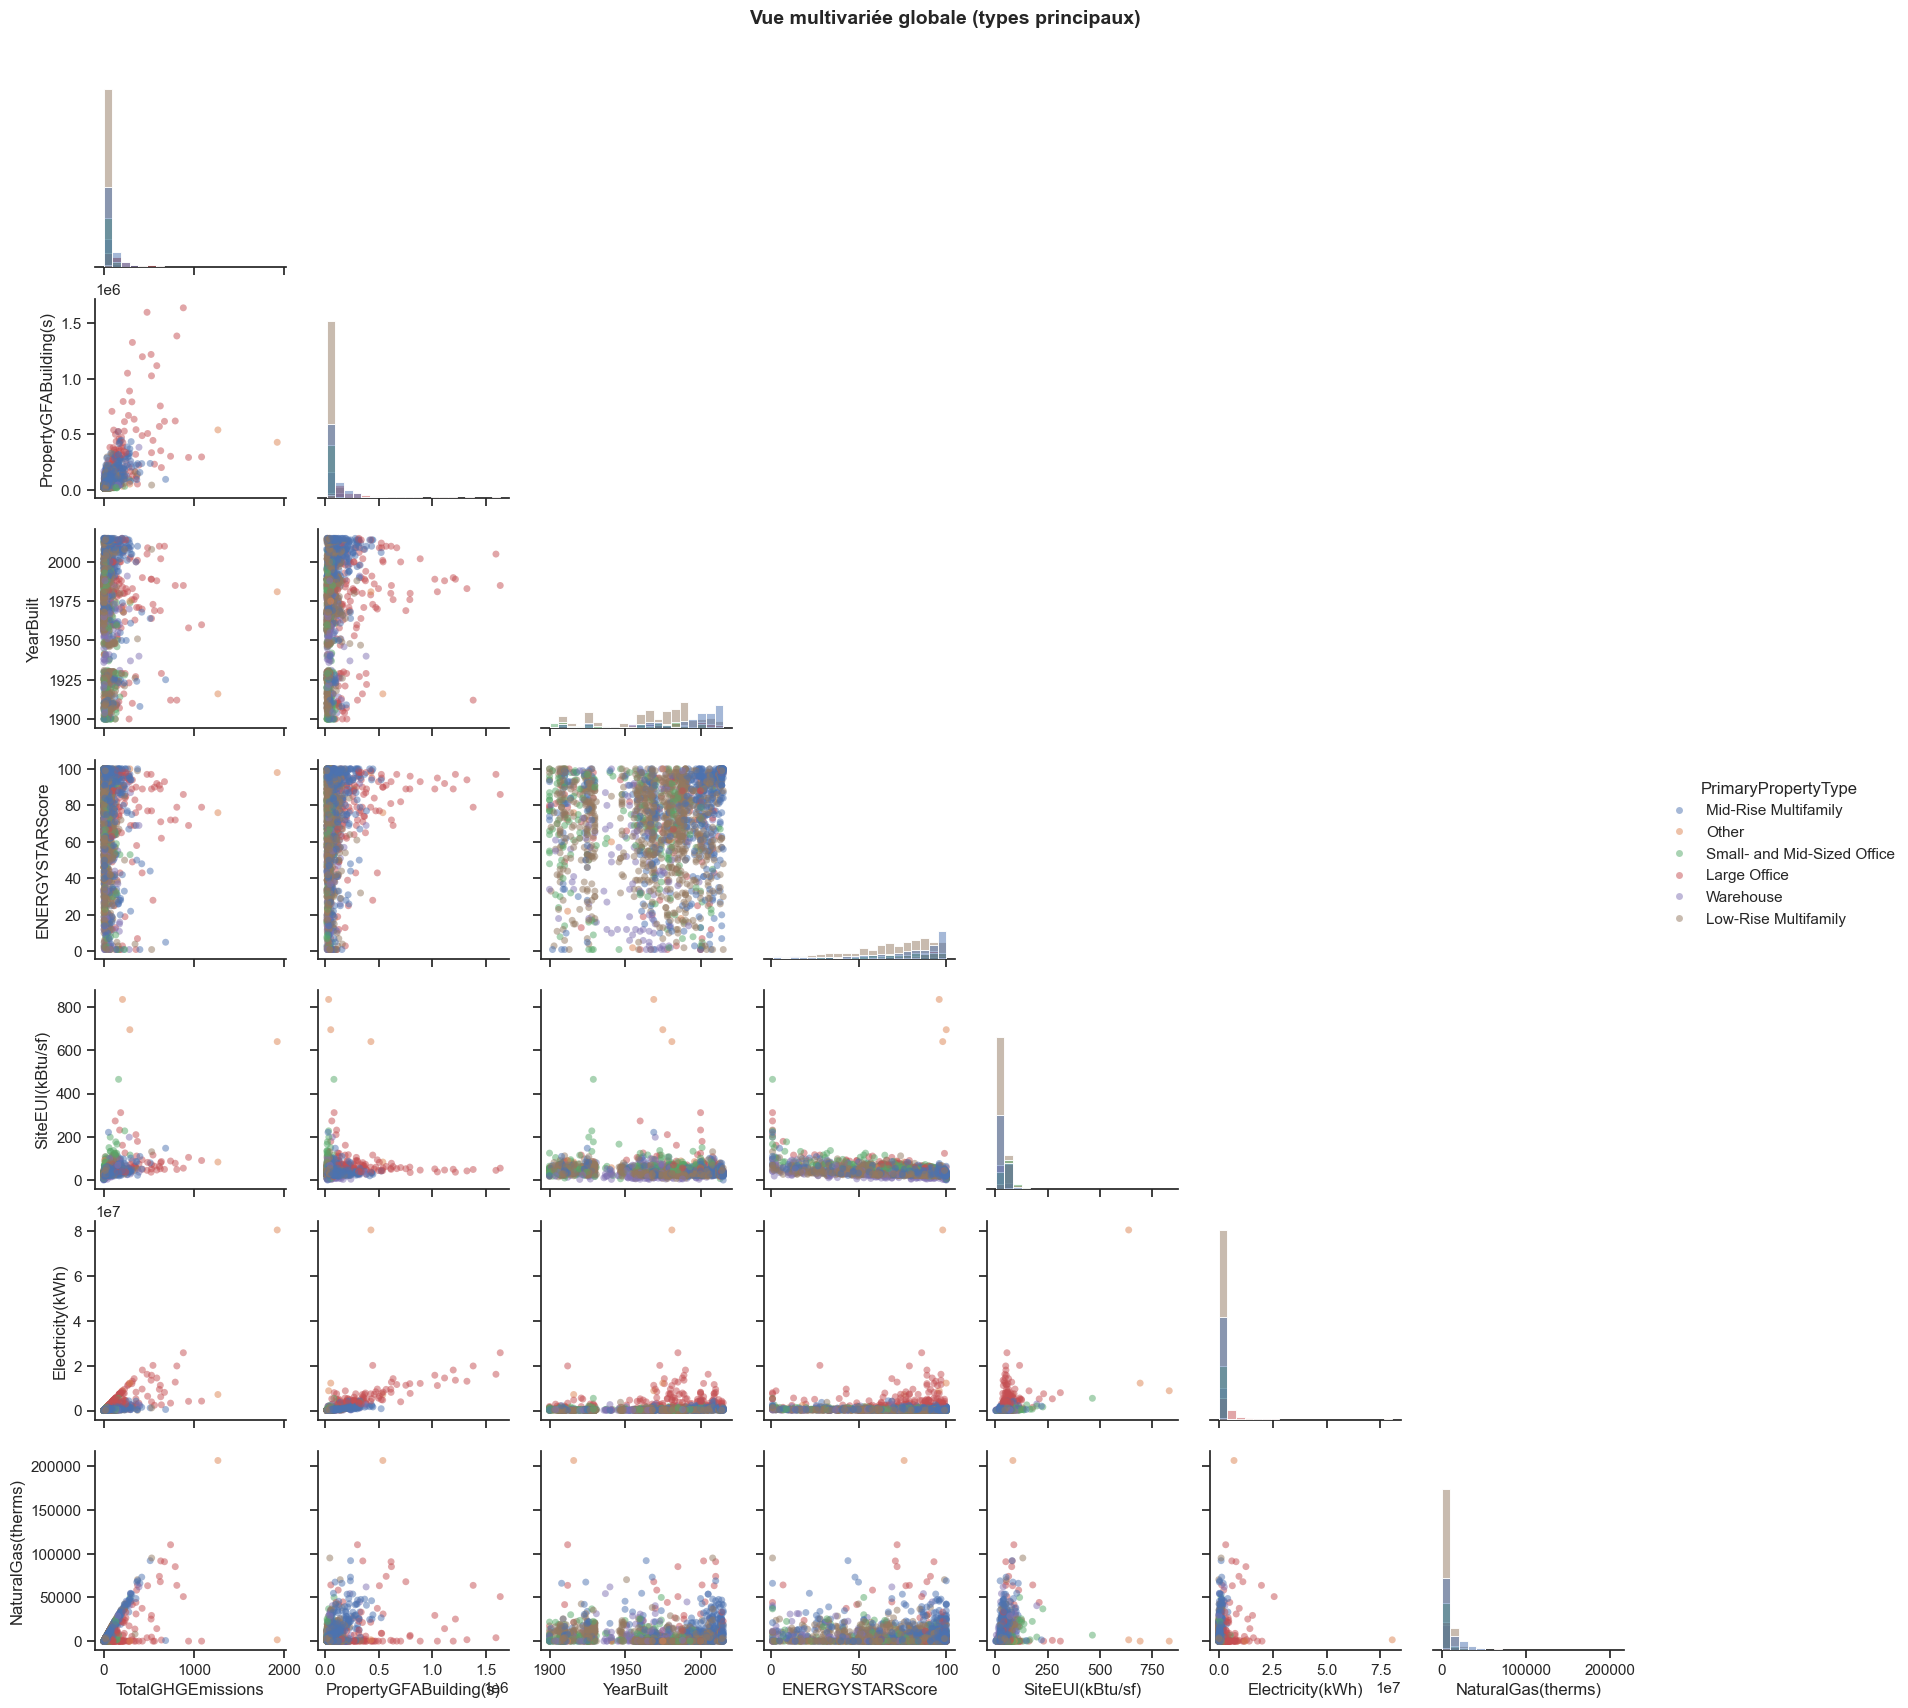

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables à tracer
cols_num = [
    "TotalGHGEmissions",
    "PropertyGFABuilding(s)",
    "YearBuilt",
    "ENERGYSTARScore",
    "SiteEUI(kBtu/sf)",
    "Electricity(kWh)",
    "NaturalGas(therms)",
]

hue_col = "PrimaryPropertyType"

# Sous-échantillon des catégories les plus fréquentes pour garder de la lisibilité
top_k = 6
top_types = (
    df_raw[hue_col]
    .value_counts()
    .head(top_k)
    .index
)

df_plot = (
    df_raw[df_raw[hue_col].isin(top_types)]
    .dropna(subset=cols_num + [hue_col])
)

sns.set_theme(style="ticks")
pair = sns.pairplot(
    df_plot,
    vars=cols_num,
    hue=hue_col,
    diag_kind="hist",
    corner=True,           # diagonale inférieure uniquement
    plot_kws={"alpha": 0.5, "s": 25, "edgecolor": "none"},
    diag_kws={"bins": 20, "edgecolor": "white"},
    height=2.4
)
pair.fig.suptitle("Vue multivariée globale (types principaux)", y=1.02, fontsize=14, weight="bold")
plt.show()


### Impact de la taille et des typologies

On observe une corrélation positive entre la surface (PropertyGFABuilding) et les émissions, avec une sensibilité à l'échelle plus marquée pour les bureaux que pour le résidentiel. Visuellement, une hiérarchie claire se dessine : les entrepôts et le résidentiel de faible hauteur occupent la zone de faibles émissions, tandis que les grands complexes de bureaux dominent le haut de la distribution.

### Profil de consommation énergétique

La nature de l'énergie influence la prévisibilité des résultats : la relation avec l'électricité est quasi linéaire (facteur d'émission stable), alors que celle avec le gaz naturel est plus diffuse. Les bureaux se distinguent par une double dominance dans la consommation de ces deux vecteurs énergétiques.

### Performance et efficacité énergétique

L'analyse des indicateurs révèle des comportements hétérogènes :

- Efficacité : Malgré une forte dispersion, les scores ENERGY STAR élevés sont associés à des consommations réduites dans certains segments de bureaux.

- Intensité (Site EUI) : On note une hétéroscédasticité marquée, la variance des émissions s'accroissant avec l'intensité énergétique, surtout pour les bureaux.

- Âge : Ce n'est pas un prédicteur linéaire simple, bien que les constructions post-1980 présentent un regroupement plus net que les bâtiments d'avant 1950.

### Propriétés statistiques et distribution

La structure des données est marquée par une forte asymétrie à droite pour la surface, l'énergie et les émissions, indiquant une minorité de très grands émetteurs. Des masses de probabilité (valeurs nulles en énergie) et des traces verticales (valeurs discrètes du score ENERGY STAR) caractérisent également les distributions.

# Section 2 : Hypothèses d'interactions et tests

In [ ]:
# code

# Section 3 : Analyse conditionnelle — Effets contextuels

In [ ]:
# code

# Section 4 : Clustering exploratoire

In [ ]:
# code

# Section 5 : Réduction dimensionnelle — PCA (Principal Component Analysis)

In [ ]:
# code

# Section 6 : Blueprint de Feature Engineering

In [ ]:
# code